## 프로젝트 개요: ⚽️ 축구 시맨틱 세그멘테이션

▪ 데이터 소스: Kaggle - Football Semantic Segmentation

▪ 목표: 축구 경기 이미지를 11개의 클래스 (선수, 심판, 잔디, 공 등)로 픽셀 단위 분할(Semantic Segmentation)을 수행한다.

▪ 평가 지표: CELoss와 DiceLoss를 사용하여 모델의 성능을 정량적으로 평가한다.

▪ 핵심 방법론: 다양한 데이터 증강 기법을 적용하여 모델 성능 변화를 분석하고, 최적의 증강 조합을 도출하여 세그멘테이션 정확도를 극대화한다.


In [1]:
import os
import random
import time
import datetime
import sys
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import List, Tuple, Dict

import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from filelock import FileLock

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models
from torchvision import transforms as T
from torchvision.transforms import v2

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import typing  # 타입 힌트 사용을 위해 추가
    

# ════════════════════════════════════════
# ▣ Meta/유틸리티함수.
# ════════════════════════════════════════
ver = "2025.11.29.002"
#BASE_DIR = r"D:\01.project\CodeIt\mission8\data"
#BASE_DIR = "/content/drive/MyDrive/codeit/mission8/data"
#BASE_DIR = r"d:\01.project\codeitmission8\mission8\data"
BASE_DIR = r"D:\01.project\CodeIt\data"
LOG_FILE = f"{BASE_DIR}/m8log.txt"
RESULT_CSV = f"{BASE_DIR}/m8result.csv"
BASE_DIR = f"{BASE_DIR}/football"

## 구분선 출력 함수
def Lines(text="", count=100):
    print("═" * count)
    if text != "":
        print(f"{text}")
        print("═" * count)
## 현재 시간 문자열 반환 함수
def now_str():
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
## 디렉토리 생성 함수
def makedirs(d):
    os.makedirs(d, exist_ok=True)
## 운영 로그 함수
def OpLog(log, bLines=True):
    if bLines:
        Lines(f"[{now_str()}] {log}")
    try:
        caller_name = sys._getframe(1).f_code.co_name
    except Exception:
        caller_name = "UnknownFunction"
        
    log_filename = LOG_FILE
    log_lock_filename = log_filename + ".lock"
    log_content = f"[{now_str()}] {caller_name}: {log}\n"
    try:
        lock = FileLock(log_lock_filename, timeout=10)
        with lock:
            with open(log_filename, 'a', encoding='utf-8') as f:
                f.write(log_content)
    except Exception as e:
        print(f"로그 파일 쓰기 오류 발생: {e}")

OpLog("Program started.2025.11.27.001", bLines=True)

## 그래픽 출력 함수
def ShowPlt(plt):
    # plt.tight_layout()
    # plt.show(block = False)
    # plt.pause(3)
    plt.close()
   
## 메타 클래스 - 전역 설정 및 데이터 정보 관리
class MyMeta():
    def __init__(self):
        self._original_files, self._fuse_files, self._image_folder =   ViewDir()
        self._color_to_label = self.get_unique_colors()
        self._num_classes = len(self._color_to_label)
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._num_epochs=50
        self._lr=0.005
        self._result_csv = f"{BASE_DIR}/result.csv"

    def original_files(self):
        return self._original_files
    def fuse_files(self):
        return self._fuse_files
    def image_folder(self):
        return self._image_folder
    def device(self):
        return self._device
    def num_classes(self):
        return self._num_classes
    def color_to_label(self):
        return self._color_to_label
    def lr(self):
        return self._lr
    def num_epochs(self):
        return self._num_epochs
    def result_csv(self):
        return self._result_csv
 
    def get_unique_colors(self, max_classes=11):
        ## 마스크 이미지에서 고유 색상을 추출하여 클래스 ID에 매핑
        color_list = []
        for mask_file in self._fuse_files:
            mask_path = os.path.join(self._image_folder, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            if mask is None:
                continue
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

            for color in unique_colors:
                color_tuple = tuple(color)
                if color_tuple not in color_list:
                    color_list.append(color_tuple)  # 고유한 색상 저장

                # 클래스 개수가 max_classes개가 되면 중단
                if len(color_list) >= max_classes:
                    # 색상 리스트를 dict로 변환 (색상 -> 클래스 ID)
                    return {color: idx for idx, color in enumerate(color_list)}
        # 모든 마스크를 순회 후 반환 (색상 -> 클래스 ID)
        return {color: idx for idx, color in enumerate(color_list)}
## 데이터셋 확인 및 로드
def ViewDir():
    ## 이미지와 마스크 파일 경로 확인 및 매칭
    ## 폴더 내 모든 파일 목록 가져오기
    image_folder = os.path.join(BASE_DIR, "images")
    file_list = os.listdir(image_folder)

    ## 원본 이미지(.jpg)와 fuse 이미지 매칭
    original_files = sorted([f for f in file_list if f.endswith(".jpg")])
    fuse_files = sorted([f for f in file_list if "fuse" in f])

    ## 이미지 로드 및 확인
    image_pairs = []
    for orig_file in original_files:
        ## 동일한 프레임의 fuse 파일 찾기
        base_name = orig_file.replace(".jpg", "")
        fuse_file = next((f for f in fuse_files if base_name in f), None)

        if fuse_file:
            ## 원본과 마스크 로드
            img_path = os.path.join(image_folder, orig_file)
            mask_path = os.path.join(image_folder, fuse_file)

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path)

            if img is not None and mask is not None:
                image_pairs.append((img, mask))

    ## 최종적으로 로드된 이미지 쌍 개수 출력
    Lines(f"{len(image_pairs)} pairs")
    return original_files, fuse_files, image_folder

## 이미지 시각화 함수
def ViewImage(original_files,fuse_files,image_folder):
    sample_image_pairs = []
    num_samples = 5

    for orig_file in original_files[:num_samples]:
        base_name = orig_file.replace(".jpg", "")
        fuse_file = next((f for f in fuse_files if base_name in f), None)

        if fuse_file:
            sample_image_pairs.append((orig_file, fuse_file))

    # 이미지 5쌍 시각화
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i, (orig_file, fuse_file) in enumerate(sample_image_pairs):
        # 이미지 로드
        orig_img = cv2.imread(os.path.join(image_folder, orig_file))
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # OpenCV BGR → RGB 변환

        fuse_img = cv2.imread(os.path.join(image_folder, fuse_file))
        fuse_img = cv2.cvtColor(fuse_img, cv2.COLOR_BGR2RGB)  # 마스크도 RGB 변환

        # 시각화
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Original: {orig_file}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(fuse_img)
        axes[i, 1].set_title(f"Fuse Mask: {fuse_file}")
        axes[i, 1].axis("off")
    ShowPlt(plt)

## 테스트용 디렉토리 및 이미지 뷰어
def TestDirView():
    original_files, fuse_files, image_folder =   ViewDir()
    ViewImage(original_files,fuse_files,image_folder)

TestDirView()

## meta 인스턴스 생성
MY_META = MyMeta()
## 고유 색상 및 클래스 매핑 출력
print(MY_META.get_unique_colors())


d:\01.project\CodeIt\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


════════════════════════════════════════════════════════════════════════════════════════════════════
[2025-12-01 09:51:37] Program started.2025.11.27.001
════════════════════════════════════════════════════════════════════════════════════════════════════
════════════════════════════════════════════════════════════════════════════════════════════════════
100 pairs
════════════════════════════════════════════════════════════════════════════════════════════════════
════════════════════════════════════════════════════════════════════════════════════════════════════
100 pairs
════════════════════════════════════════════════════════════════════════════════════════════════════
{(np.uint8(27), np.uint8(71), np.uint8(151)): 0, (np.uint8(111), np.uint8(48), np.uint8(253)): 1, (np.uint8(254), np.uint8(233), np.uint8(3)): 2, (np.uint8(255), np.uint8(0), np.uint8(29)): 3, (np.uint8(255), np.uint8(159), np.uint8(0)): 4, (np.uint8(255), np.uint8(160), np.uint8(1)): 5, (np.uint8(0), np.uint8(0), np.ui

## 축구 시맨틱 세그멘테이션 증강 Transform


### A. 기본 증강

가장 **일반적이고 필수적인** 증강 및 전처리 단계.

| 순서 | 변환 (Transform) | 목적 | 상세 내용 |
| :---: | :--- | :--- | :--- |
| 1 | `v2.Resize((256, 256))` | **크기 조정** | 모든 이미지를 256x256 픽셀로 조정합니다. |
| 2 | `v2.RandomHorizontalFlip(p=0.5)` | **좌우 반전** | 50% 확률로 수평으로 뒤집습니다. |
| 3 | `v2.ColorJitter(...)` | **색상 변화** | 밝기, 대비, 채도, 색조를 무작위로 변경합니다. |
| 4 | `v2.ToTensor()` | **Tensor 변환** | 이미지를 PyTorch Tensor로 변환 및 `[0, 1]` 정규화합니다. |
| 5 | `v2.Normalize(...)` | **정규화** | ImageNet 표준값으로 표준화합니다. |


### B. 강력 증강

A 유형에 **기하학적 및 노이즈 증강**을 추가하여 모델의 **강건성** 향상.

| 순서 | 변환 (Transform) | 목적 | 상세 내용 |
| :---: | :--- | :--- | :--- |
| 1-3 | `v2.Resize`, `Flip`, `Jitter` | **기본 증강** | A 유형과 동일한 기본 변환 적용 |
| 4 | `v2.RandomRotation(degrees=15)` | **무작위 회전** | $\pm 15$도 범위 내에서 무작위 회전 (**추가**) |
| 5 | `v2.RandomAffine(...)` | **어파인 변환** | 최대 10% 이동 및 90%~110% 크기 조정 (**추가**) |
| 6 | `v2.GaussianBlur(...)` | **가우시안 블러** | 무작위 블러 적용 (**추가**) |
| 7 | `v2.RandomErasing(...)` | **무작위 소거** | 30% 확률로 이미지의 일부 영역 가림 (**추가**) |
| 8-9 | `v2.ToTensor`, `v2.Normalize` | **전처리** | A 유형과 동일한 전처리 적용 |


### C. Segmentation 최적화 증강 (원근 추가)

B 유형에서 **Resize**를 제거하고 **시맨틱 세그멘테이션에 중요한 원근 변환 (`RandomPerspective`)**을 추가.

| 순서 | 변환 (Transform) | 변경/추가 사항 | 목적 |
| :---: | :--- | :--- | :--- |
| 1 | `v2.RandomResizedCrop(...)` | `v2.Resize` **대체**. | **스케일 및 부분 영역 학습** 유도 |
| 2-4 | `v2.RandomHorizontalFlip` 외 2종 | B 유형 유지. | |
| 5 | **`v2.RandomPerspective(...)`** | **핵심 추가**. | **다양한 카메라 시점 및 원근 왜곡** 학습 |
| 6-8 | `v2.ColorJitter` 외 2종 | B 유형 유지. | |
| 9-10 | `v2.ToTensor`, `v2.Normalize` | B 유형 유지. | |


### D. 최강 증강 (C + 화질 변화 대응)

C 유형에 **`v2.RandomAdjustSharpness`**를 추가하여 다양한 영상/사진 화질 변화에 대한 모델의 **강건성**을 확보한 최종 추천 파이프라인.

| 순서 | 변환 (Transform) | 변경/추가 사항 | 목적 |
| :---: | :--- | :--- | :--- |
| 1-5 | `v2.RandomResizedCrop` ~ `v2.RandomPerspective` | C 유형 기하학적 증강 유지. | **강력한 시점 및 스케일 학습** |
| 6-7 | `v2.ColorJitter`, `v2.GaussianBlur` | C 유형 유지. | |
| 8 | **`v2.RandomAdjustSharpness(...)`** | **화질 변화 대응 추가**. | 이미지의 **선명도**를 무작위로 변경하여 강건성 확보 |
| 9 | `v2.RandomErasing(...)` | C 유형 유지. | |
| 10-11 | `v2.ToTensor`, `v2.Normalize` | C 유형 유지. | **필수 전처리** |


## ✅ 결론 및 권장 사항

축구 시맨틱 세그멘테이션 작업은 **픽셀 단위의 정확도**와 **다양한 촬영 환경**에 대한 일반화가 중요하다.

Type D는 RandomPerspective를 통한 강력한 시점 변화 학습과 RandomAdjustSharpness를 통한 화질 변화 대응 능력을 모두 갖추고 있어, 해당 데이터셋에 대한 학습 성능을 가장 극대화할 수 있다.

In [2]:
# ════════════════════════════════════════
# ▣ Transform/Dataset/DataLoader
# ════════════════════════════════════════

## 데이터 증강 및 전처리 함수
def GetTransfrom(type: str = "A", crop_size: int = 256) -> typing.Callable:
    # type (str): 사용할 변환 유형 ("A", "B", "C", "D").
    # crop_size (int): 이미지 출력 크기 (C, D 유형에서 사용).
    # return : Callable: PyTorch transforms.v2.Compose 객체.
    # ----------------------------------------
    # A 유형: 기본 증강 (Resize 기반)
    # ----------------------------------------
    if type == "A":
        ## ★ 데이터 증강을 포함한 학습용 변환
        train_transform = v2.Compose([
            v2.Resize((256, 256)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        return train_transform
        
    # ----------------------------------------
    # B 유형: 강력 증강 (기하학적/노이즈 추가, Resize 기반)
    # ----------------------------------------
    elif type == "B":
        train_transform = v2.Compose([
            v2.Resize((256, 256)),
            # 기존 증강
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            
            # 추가 증강
            v2.RandomRotation(degrees=15), 
            v2.RandomAffine(
                degrees=0,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
            ),
            v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            v2.RandomErasing(p=0.3, scale=(0.02, 0.1)),
            
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        return train_transform

    # ----------------------------------------
    # C 유형: Segmentation 최적화 증강 (Perspective 추가, Sharpness 제외)
    # ----------------------------------------
    elif type == "C":
        train_transform = v2.Compose([
            # 1. 시점 변화 및 스케일 학습을 위해 RandomResizedCrop 사용 (Resize 대체)
            v2.RandomResizedCrop(crop_size, scale=(0.8, 1.2)), 
            
            # 2. 기하학적 증강
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=15), 
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            v2.RandomPerspective(distortion_scale=0.5, p=0.7), # ★ 핵심 추가
            
            # 3. 색상 및 노이즈 증강
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            v2.RandomErasing(p=0.3, scale=(0.02, 0.1)),
            
            # 4. 필수 전처리
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        return train_transform
        
    # ----------------------------------------
    # D 유형: C 유형 + Sharpness 추가 (최강/최종 추천)
    # ----------------------------------------
    elif type == "D":
        train_transform = v2.Compose([
            # 1. 시점 변화 및 스케일 학습
            v2.RandomResizedCrop(crop_size, scale=(0.8, 1.2)), 
            
            # 2. 강력한 기하학적 증강
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=15), 
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            v2.RandomPerspective(distortion_scale=0.5, p=0.7),
            
            # 3. 색상, 노이즈 및 화질 증강
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            v2.RandomErasing(p=0.3, scale=(0.02, 0.1)),
            v2.RandomAdjustSharpness(sharpness_factor=0.5, p=0.5), # ★ D 유형에 추가된 샤프니스 증강
            
            # 4. 필수 전처리
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        return train_transform

    else:
        # A, B, C, D 유형 외의 잘못된 type이 입력되었을 때 예외 처리
        raise ValueError(f"Unknown transform type: {type}. Please use 'A', 'B', 'C', or 'D'.")
    

## 데이터셋 클래스 정의
class FootballDataset(Dataset):
    ## 축구 이미지 세그멘테이션 데이터셋 - RGB 마스크를 클래스 레이블로 변환
    def __init__(self, trainsform, image_files, mask_files, image_folder, color_to_label, train=False ):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_folder = image_folder
        self.color_to_label = color_to_label  # 고정된 클래스 매핑
        self.train = train
        self.train_transform = trainsform 
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.image_folder, self.mask_files[idx])

        # 원본 이미지 로드
        img = Image.open(img_path).convert("RGB")

        # 마스크 로드 (RGB 모드)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # RGB 마스크를 클래스 레이블 맵으로 변환
        mask_class = np.zeros(mask.shape[:2], dtype=np.uint8)
        for color_tuple, label in self.color_to_label.items():
            color_array = np.array(color_tuple)
            mask_class[(mask == color_array).all(axis=-1)] = label

        mask = torch.tensor(mask_class, dtype=torch.long)

        # 데이터 증강 적용 (학습 시에만)
        if self.train:
            # 이미지와 마스크를 함께 변환
            img = T.ToTensor()(img) # 0-1 range
            img, mask = self.train_transform(img, mask)
        else:
            # 검증/테스트 시에는 리사이즈와 정규화만 적용
            transform = v2.Compose([
                v2.Resize((256, 256)),
                v2.ToTensor(),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            img = transform(img)
            mask = torch.tensor(cv2.resize(mask_class, (256, 256), interpolation=cv2.INTER_NEAREST), dtype=torch.long)

        return img, mask

print("Define FootballDataset class")

## 데이터 로더 함수
def GetLoader(transform_type="A"):
    ## 학습/테스트 데이터 로더 생성 (8:2 분할)
    Lines("Load Dataset")

    color_to_label = MY_META.color_to_label()
    Lines(f"Unique colors found: {len(color_to_label)}")

    ## 데이터 로드
    original_files = MY_META.original_files()
    fuse_files = MY_META.fuse_files()
    image_folder = MY_META.image_folder()
    transform = GetTransfrom(transform_type)
    dataset = FootballDataset(transform, original_files, fuse_files, image_folder, color_to_label)
    
    ## 데이터셋 분할
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)

    ## 서브셋 생성
    train_dataset = torch.utils.data.Subset(FootballDataset(transform, original_files, fuse_files, image_folder, color_to_label, train=True), train_indices)
    test_dataset = torch.utils.data.Subset(FootballDataset(transform,original_files, fuse_files, image_folder, color_to_label, train=False), test_indices)

    ## DataLoader 생성
    Lines(f"Train Data: {len(train_dataset)}, Test Data: {len(test_dataset)}")
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
    return train_loader, test_loader

## 데이터 로더 테스트 함수.
def TestLoader():
    train_loader, test_loader = GetLoader()
    print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")
TestLoader()


Define FootballDataset class
════════════════════════════════════════════════════════════════════════════════════════════════════
Load Dataset
════════════════════════════════════════════════════════════════════════════════════════════════════
════════════════════════════════════════════════════════════════════════════════════════════════════
Unique colors found: 11
════════════════════════════════════════════════════════════════════════════════════════════════════
════════════════════════════════════════════════════════════════════════════════════════════════════
Train Data: 80, Test Data: 20
════════════════════════════════════════════════════════════════════════════════════════════════════
Train batches: 10, Test batches: 20


d:\01.project\CodeIt\.venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### 평가 지표 함수 

평가를 측정 하는 함수와 저장 함수

In [ ]:
# ════════════════════════════════════════
# ▣ 평가 지표 및 모델 관리
# ════════════════════════════════════════
## 평가 지표 저장 함수.csv파일에 저장.
def save_metrics_to_csv(metrics, params_name, transform_type,epochs, learnRate, epoch_index, data_set_name):
    mAP = metrics.get('mAP', 0.0)
    avg_loss = metrics.get('avg_loss', 0.0)
    ce_loss = metrics.get('ce_loss', 0.0)
    dice_loss = metrics.get('dice_loss', 0.0)
    accuracy = metrics.get('accuracy', 0.0)
    precision = metrics.get('precision', 0.0)
    recall = metrics.get('recall', 0.0)
    f1_score = metrics.get('f1_score', 0.0)
    
    new_data = {
        'timestamp':now_str(), 'Strategy': [params_name],
        'Transform': [transform_type], 'Max_Epochs': [epochs], 'Epoch_Index': [epoch_index],
        'DataSet': [data_set_name], 'LearnRate': [learnRate], 
        'TotalLoss': [avg_loss], 'CELoss': [ce_loss], 'DiceLoss': [dice_loss],
        'Accuracy': [accuracy], 'mIoU': [mAP],
        'Precision': [precision], 'Recall': [recall], 'F1Score': [f1_score],
        'TN': [0], 'FP': [0], 'FN': [0], 'TP': [0]
    }
    filename = RESULT_CSV
    lock_filename = filename + ".lock"
    new_df = pd.DataFrame(new_data)
    
    try:
        makedirs(os.path.dirname(filename))
        lock = FileLock(lock_filename, timeout=10)
        with lock:
            if os.path.exists(filename):
                try:
                    existing_df = pd.read_csv(filename)
                    updated_df = pd.concat([existing_df, new_df], ignore_index=True)
                    updated_df.to_csv(filename, index=False)
                except:
                    new_df.to_csv(filename, index=False)
            else:
                new_df.to_csv(filename, index=False)
    except Exception as e:
        print(f"CSV 저장 중 오류 발생: {e}")
        OpLog(f"Error saving CSV: {e}")
    OpLog(f"Metrics saved: {data_set_name} Epoch {epoch_index}, mIoU: {mAP:.4f}")

## 평가 지표 계산 함수. 
def calculate_metrics(pred_masks, true_masks, num_classes):
    # ▶ mIoU, Accuracy, Precision, Recall, F1-Score 계산
    # Flatten
    pred_flat = pred_masks.flatten()
    true_flat = true_masks.flatten()
    
    # Pixel Accuracy
    correct = (pred_flat == true_flat).sum()
    total = len(true_flat)
    accuracy = correct / total
    
    # Per-class metrics
    iou_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    
    for cls in range(num_classes):
        pred_inds = (pred_flat == cls)
        target_inds = (true_flat == cls)
        
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        
        # IoU
        if union == 0:
            iou_list.append(float('nan')) # Ignore if class not present
        else:
            iou_list.append(intersection / union)
            
        # Precision & Recall
        pred_sum = pred_inds.sum()
        target_sum = target_inds.sum()
        
        prec = intersection / pred_sum if pred_sum > 0 else 0.0
        rec = intersection / target_sum if target_sum > 0 else 0.0
        
        precision_list.append(prec)
        recall_list.append(rec)
        
        # F1
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
        f1_list.append(f1)
        
    # Mean metrics (ignoring NaNs for IoU)
    mIoU = np.nanmean(iou_list)
    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)
    mean_f1 = np.mean(f1_list)
    
    return {
        'accuracy': accuracy,
        'mAP': mIoU, # Using mAP field for mIoU as requested/common
        'precision': mean_precision,
        'recall': mean_recall,
        'f1_score': mean_f1
    }

## Dice Loss 정의
class DiceLoss(nn.Module):
    # ▶ 세그멘테이션용 Dice Loss
    def __init__(self, num_classes, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, outputs, targets):
        # ▶ outputs: (B,C,H,W) logits, targets: (B,H,W) class indices
        # Softmax를 적용하여 확률로 변환
        probs = F.softmax(outputs, dim=1)
        
        # One-hot encoding for targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        # Flatten
        probs_flat = probs.contiguous().view(-1)
        targets_flat = targets_one_hot.contiguous().view(-1)
        
        # Dice coefficient
        intersection = (probs_flat * targets_flat).sum()
        dice = (2. * intersection + self.smooth) / (probs_flat.sum() + targets_flat.sum() + self.smooth)
        
        return 1 - dice

## 평가 이미지 저장 함수 
def SaveEvalImages(images, true_masks, pred_masks, modelName, transformType, numEpoch, lr ,epochIndex, max_images=10):
    # ▶ 평가 결과 이미지 저장 (원본, GT, 예측) - 최대 max_images개까지
    save_dir = f"{BASE_DIR}/modelfiles/eval_images/{modelName}_{transformType}_{numEpoch}_{lr}"
    makedirs(save_dir)  # 디렉토리가 없으면 생성
    
    # 배치 크기와 max_images 중 작은 값 선택
    num_to_save = min(images.size(0), max_images)
    
    # 여러 이미지를 한 파일에 저장
    fig, axes = plt.subplots(num_to_save, 3, figsize=(15, 5 * num_to_save))
    
    # axes가 1차원 배열인 경우 2차원으로 변환
    if num_to_save == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_to_save):
        # 이미지 데이터 추출
        img = images[i].cpu().permute(1, 2, 0).numpy()
        true_mask = true_masks[i].cpu().numpy()
        pred_mask = pred_masks[i].cpu().numpy()

        # 역정규화
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # 시각화
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Sample {i+1} - Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_mask, cmap='jet')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='jet')
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')

    plt.suptitle(f"Model: {modelName} ({transformType}) - Epoch {epochIndex}/{numEpoch}", fontsize=16)
    plt.tight_layout()
    
    saveFileName = f"{save_dir}/{modelName}_{transformType}_{numEpoch}_{lr}_{epochIndex}.png"
    plt.savefig(saveFileName)
    plt.close(fig)
    OpLog(f"Saved {num_to_save} evaluation images to {saveFileName}")

## 테스트용 평가 이미지 저장 함수
def TestSaveEvalImages():
    train_loader, test_loader = GetLoader()
    model = UNet(MY_META.num_classes())
    model.load_state_dict(torch.load(f"{BASE_DIR}/modelfiles/UNet_50_1.pth"))
    model.eval()
    SaveEvalImages(*next(iter(test_loader)), model.getMyName(), model.getTransformType(), 50, 1)
#TestSaveEvalImages()


# 학습 및 추론 클래스 

##  U-Net / Advanced U-Net / Transfer Learning U-Net 구조 비교

### 1. U-Net (기본 U-Net)

| 단계 | 채널 수 (Channels) | 해상도 (Resolution) |
|------|--------------------|---------------------|
| 입력 (Image) | 3 | H × W |
| Encoder1 | 64 | H × W |
| Encoder2 | 128 | H/2 × W/2 |
| Encoder3 | 256 | H/4 × W/4 |
| Bottleneck | 512 | H/8 × W/8 |
| UpConv3 + Decoder3 | 256 | H/4 × W/4 |
| UpConv2 + Decoder2 | 128 | H/2 × W/2 |
| UpConv1 + Decoder1 | 64 | H × W |
| 최종 출력 | NumClasses | H × W |

---

### 2. Advanced U-Net (Attention 적용)

| 단계 | 채널 수 (Channels) | 해상도 (Resolution) |
|------|--------------------|---------------------|
| 입력 (Image) | 3 | H × W |
| Encoder1 | 64 | H × W |
| Encoder2 | 128 | H/2 × W/2 |
| Encoder3 | 256 | H/4 × W/4 |
| Bottleneck | 512 | H/8 × W/8 |
| UpConv3 + Attention + Decoder3 | 256 | H/4 × W/4 |
| UpConv2 + Attention + Decoder2 | 128 | H/2 × W/2 |
| UpConv1 + Attention + Decoder1 | 64 | H × W |
| 최종 출력 | NumClasses | H × W |

---

### 3. Transfer Learning U-Net (ResNet34 백본)

| 단계 | 채널 수 (Channels) | 해상도 (Resolution) |
|------|--------------------|---------------------|
| 입력 (Image) | 3 | H × W |
| Encoder1 (ResNet conv1+bn1+relu) | 64 | H/2 × W/2 |
| Encoder2 (ResNet layer1) | 64 | H/4 × W/4 |
| Encoder3 (ResNet layer2) | 128 | H/8 × W/8 |
| Encoder4 (ResNet layer3) | 256 | H/16 × W/16 |
| Bottleneck (ResNet layer4) | 512 | H/32 × W/32 |
| UpConv4 + Decoder4 | 256 | H/16 × W/16 |
| UpConv3 + Decoder3 | 128 | H/8 × W/8 |
| UpConv2 + Decoder2 | 64 | H/4 × W/4 |
| UpConv1 + Decoder1 | 64 | H/2 × W/2 |
| 최종 출력 (Interpolate ×2) | NumClasses | H × W |

---

* TransferLearningUNet은 ResNet34 백본을 사용하기 때문에 해상도 축소가 더 깊게(H/32까지) 진행된다는 점이 차별점.  


In [4]:

# ════════════════════════════════════════
# ▣ 모델 클래스 정의
# ════════════════════════════════════════
## 모델 저장 함수 
def SaveModel(model,epochs,epochIndex):
    save_dir = f"{BASE_DIR}/modelfiles"
    makedirs(save_dir)
    torch.save(model.state_dict(), f"{save_dir}/{model.getMyName()}_{model.getTransformType()}_{epochs}_{model.getLr()}_{epochIndex}.pth")

## 모델 로드 함수
def LoadModel(model,epochs,epochIndex):
    model.load_state_dict(torch.load(f"{BASE_DIR}/modelfiles/{model.getMyName()}_{model.getTransformType()}_{epochs}_{model.getLr()}_{epochIndex}.pth"))
    model.eval()

## BaseModel 클래스
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self._name = "BaseModel"
        self._epochs = MY_META.num_epochs()
        self._lr = MY_META.lr()
        self._transform_type = "A"
        self._num_classes = MY_META.num_classes()

    ## 모델 이름 반환
    def getMyName(self):
        return self._name

    def getEpochs(self):
        return self._epochs
    def getLr(self):
        return self._lr
    def getTransformType(self):
        return self._transform_type
    
    def fit_org(self, train_loader, test_loader, num_epochs, lr):
        device = MY_META.device()
        ce_criterion = nn.CrossEntropyLoss()
        dice_criterion = DiceLoss(num_classes=MY_META.num_classes())
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

        for epoch in range(num_epochs):
            self.train()
            running_ce_loss = 0.0
            running_dice_loss = 0.0
            running_total_loss = 0.0
            
            for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                images, masks = images.to(device), masks.to(device)
                optimizer.zero_grad()
                outputs = self(images)
                
                ### Cross Entropy Loss와 Dice Loss를 결합
                ce_loss = ce_criterion(outputs, masks)
                dice_loss = dice_criterion(outputs, masks)
                loss = ce_loss + dice_loss
                
                loss.backward()
                optimizer.step()
                
                running_ce_loss += ce_loss.item()
                running_dice_loss += dice_loss.item()
                running_total_loss += loss.item()

            train_ce_loss = running_ce_loss / len(train_loader)
            train_dice_loss = running_dice_loss / len(train_loader)
            train_total_loss = running_total_loss / len(train_loader)
            OpLog(f"Epoch {epoch+1} Train - CE Loss: {train_ce_loss:.4f}, Dice Loss: {train_dice_loss:.4f}, Total Loss: {train_total_loss:.4f}")

            ### 검증 단계
            self.eval()
            all_preds, all_masks = [], []
            eval_ce_loss = 0.0
            eval_dice_loss = 0.0
            eval_total_loss = 0.0
            
            index = 0
            with torch.no_grad():
                for images, masks in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Eval]"):
                    images, masks = images.to(device), masks.to(device)
                    outputs = self(images)
                    
                    #### Cross Entropy Loss와 Dice Loss 계산
                    ce_loss = ce_criterion(outputs, masks)
                    dice_loss = dice_criterion(outputs, masks)
                    total_loss = ce_loss + dice_loss
                    
                    eval_ce_loss += ce_loss.item()
                    eval_dice_loss += dice_loss.item()
                    eval_total_loss += total_loss.item()
                    
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.append(preds.cpu())
                    all_masks.append(masks.cpu())
                    index += 1
                    msg = f"{self._name}.{self._transform_type}.{num_epochs}.{lr}.EPOCH:{epoch+1}:{index}/{len(test_loader)}:Eval Batch - CE Loss: {ce_loss.item():.4f}, Dice Loss: {dice_loss.item():.4f}, Total Loss: {total_loss.item():.4f}"
                    OpLog(msg, bLines=False)

            all_preds = torch.cat(all_preds)
            all_masks = torch.cat(all_masks)
            metrics = calculate_metrics(all_preds, all_masks, MY_META.num_classes())
            metrics['avg_loss'] = eval_total_loss / len(test_loader)
            metrics['ce_loss'] = eval_ce_loss / len(test_loader)
            metrics['dice_loss'] = eval_dice_loss / len(test_loader)
            
            OpLog(f"Epoch {epoch+1} Eval - CE Loss: {metrics['ce_loss']:.4f}, Dice Loss: {metrics['dice_loss']:.4f}, Total Loss: {metrics['avg_loss']:.4f}, mIoU: {metrics['mAP']:.4f}")
            save_metrics_to_csv(metrics, self.getMyName(),self._transform_type, num_epochs, lr, epoch + 1, "Test")
            SaveModel(self, num_epochs, epoch + 1)

            ### 에포크별 결과 시각화
            self.eval()
            with torch.no_grad():
                test_iter = iter(test_loader)
                num_samples_to_show = 10  # SaveEvalImages의 max_images와 맞춤
                
                # 시각화를 위한 이미지 수집
                all_images = []
                all_masks = []
                all_preds = []
                
                for i in range(num_samples_to_show):
                    try:
                        images, masks = next(test_iter)
                    except StopIteration:
                        break

                    images, masks = images.to(device), masks.to(device)
                    outputs = self(images)
                    preds = torch.argmax(outputs, dim=1)
                    
                    # 이미지 수집
                    all_images.append(images[0].cpu())
                    all_masks.append(masks[0].cpu())
                    all_preds.append(preds[0].cpu())

                    ### 시각화를 위해 0번째 배치 아이템 사용
                    img = images[0].cpu().permute(1, 2, 0).numpy()
                    mask = masks[0].cpu().numpy()
                    pred = preds[0].cpu().numpy()

                    ### 역정규화
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    img = np.clip(img, 0, 1)

                    plt.subplot(num_samples_to_show, 3, i * 3 + 1)
                    plt.imshow(img)
                    plt.title(f"Epoch {epoch+1} - Original")
                    plt.axis('off')

                    plt.subplot(num_samples_to_show, 3, i * 3 + 2)
                    plt.imshow(mask, cmap='jet')
                    plt.title("Ground Truth")
                    plt.axis('off')

                    plt.subplot(num_samples_to_show, 3, i * 3 + 3)
                    plt.imshow(pred, cmap='jet')
                    plt.title("Prediction")
                    plt.axis('off')

                plt.suptitle(f"Epoch {epoch+1} Results", fontsize=16)
                ShowPlt(plt)
                
                # 수집된 모든 이미지를 배치로 변환하여 저장
                if len(all_images) > 0:
                    batch_images = torch.stack(all_images)
                    batch_masks = torch.stack(all_masks)
                    batch_preds = torch.stack(all_preds)
                    SaveEvalImages(batch_images, batch_masks, batch_preds, self.getMyName(), self._transform_type, num_epochs, self.getLr(), epoch + 1)
            scheduler.step()

    ## 모델 학습 함수 CE Loss + Dice Loss 결합
    def fit(self, train_loader, test_loader, num_epochs, lr):
        device = MY_META.device()
        ce_criterion = nn.CrossEntropyLoss()
        dice_criterion = DiceLoss(num_classes=MY_META.num_classes())
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

        for epoch in range(num_epochs):
            self.train()
            running_ce_loss = 0.0
            running_dice_loss = 0.0
            running_total_loss = 0.0
            index = 0 
            for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                images, masks = images.to(device), masks.to(device)
                optimizer.zero_grad()
                outputs = self(images)
                
                ### Cross Entropy Loss와 Dice Loss를 결합
                ce_loss = ce_criterion(outputs, masks)
                dice_loss = dice_criterion(outputs, masks)
                loss = ce_loss + dice_loss
                
                loss.backward()
                optimizer.step()
                
                running_ce_loss += ce_loss.item()
                running_dice_loss += dice_loss.item()
                running_total_loss += loss.item()
                index += 1
                msg = f"{self._name}.{self._transform_type}.{num_epochs}.{lr}.EPOCH:{epoch+1}:{index}/{len(train_loader)}:Train Batch - CE Loss: {ce_loss.item():.4f}, Dice Loss: {dice_loss.item():.4f}, Total Loss: {loss.item():.4f}"
                OpLog(msg, bLines=False)


            train_ce_loss = running_ce_loss / len(train_loader)
            train_dice_loss = running_dice_loss / len(train_loader)
            train_total_loss = running_total_loss / len(train_loader)
            OpLog(f"Epoch {epoch+1} Train - CE Loss: {train_ce_loss:.4f}, Dice Loss: {train_dice_loss:.4f}, Total Loss: {train_total_loss:.4f}")

            ### 검증 단계
            self.eval()
            all_preds, all_masks = [], []
            eval_ce_loss = 0.0
            eval_dice_loss = 0.0
            eval_total_loss = 0.0
            
            index = 0
            with torch.no_grad():
                for images, masks in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Eval]"):
                    images, masks = images.to(device), masks.to(device)
                    outputs = self(images)
                    
                    #### Cross Entropy Loss와 Dice Loss 계산
                    ce_loss = ce_criterion(outputs, masks)
                    dice_loss = dice_criterion(outputs, masks)
                    total_loss = ce_loss + dice_loss
                    
                    eval_ce_loss += ce_loss.item()
                    eval_dice_loss += dice_loss.item()
                    eval_total_loss += total_loss.item()
                    
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.append(preds.cpu())
                    all_masks.append(masks.cpu())
                    index += 1
                    msg = f"{self._name}.{self._transform_type}.{num_epochs}.{lr}.EPOCH:{epoch+1}:{index}/{len(test_loader)}:Eval Batch - CE Loss: {ce_loss.item():.4f}, Dice Loss: {dice_loss.item():.4f}, Total Loss: {total_loss.item():.4f}"
                    OpLog(msg, bLines=False)

            all_preds = torch.cat(all_preds)
            all_masks = torch.cat(all_masks)
            metrics = calculate_metrics(all_preds, all_masks, MY_META.num_classes())
            metrics['avg_loss'] = eval_total_loss / len(test_loader)
            metrics['ce_loss'] = eval_ce_loss / len(test_loader)
            metrics['dice_loss'] = eval_dice_loss / len(test_loader)
            
            OpLog(f"Epoch {epoch+1} Eval - CE Loss: {metrics['ce_loss']:.4f}, Dice Loss: {metrics['dice_loss']:.4f}, Total Loss: {metrics['avg_loss']:.4f}, mIoU: {metrics['mAP']:.4f}")
            save_metrics_to_csv(metrics, self.getMyName(),self._transform_type, num_epochs, lr, epoch + 1, "Test")
            SaveModel(self, num_epochs, epoch + 1)

            ### 에포크별 결과 시각화
            self.eval()
            with torch.no_grad():
                test_iter = iter(test_loader)
                num_samples_to_show = 10  # SaveEvalImages의 max_images와 맞춤
                
                # 시각화를 위한 이미지 수집
                all_images = []
                all_masks = []
                all_preds = []
                
                for i in range(num_samples_to_show):
                    try:
                        images, masks = next(test_iter)
                    except StopIteration:
                        break

                    images, masks = images.to(device), masks.to(device)
                    outputs = self(images)
                    preds = torch.argmax(outputs, dim=1)
                    
                    # 이미지 수집
                    all_images.append(images[0].cpu())
                    all_masks.append(masks[0].cpu())
                    all_preds.append(preds[0].cpu())

                    ### 시각화를 위해 0번째 배치 아이템 사용
                    img = images[0].cpu().permute(1, 2, 0).numpy()
                    mask = masks[0].cpu().numpy()
                    pred = preds[0].cpu().numpy()

                    ### 역정규화
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    img = np.clip(img, 0, 1)

                    plt.subplot(num_samples_to_show, 3, i * 3 + 1)
                    plt.imshow(img)
                    plt.title(f"Epoch {epoch+1} - Original")
                    plt.axis('off')

                    plt.subplot(num_samples_to_show, 3, i * 3 + 2)
                    plt.imshow(mask, cmap='jet')
                    plt.title("Ground Truth")
                    plt.axis('off')

                    plt.subplot(num_samples_to_show, 3, i * 3 + 3)
                    plt.imshow(pred, cmap='jet')
                    plt.title("Prediction")
                    plt.axis('off')

                plt.suptitle(f"Epoch {epoch+1} Results", fontsize=16)
                ShowPlt(plt)
                
                # 수집된 모든 이미지를 배치로 변환하여 저장
                if len(all_images) > 0:
                    batch_images = torch.stack(all_images)
                    batch_masks = torch.stack(all_masks)
                    batch_preds = torch.stack(all_preds)
                    SaveEvalImages(batch_images, batch_masks, batch_preds, self.getMyName(), self._transform_type, num_epochs, self.getLr(), epoch + 1)
            scheduler.step()
        

## U-Net 모델 정의.(기본 U-Net)
class UNet(BaseModel):
    ## 기본 U-Net 모델 (BatchNorm 포함)
    def __init__(self,transform_type="A", epochs=50, lr=0.005):
        super(UNet, self).__init__()
        self._name = "UNet"
        self._transform_type = transform_type
        self._epochs = epochs
        self._lr = lr
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.final_conv = nn.Conv2d(64,self._num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)
        return self.final_conv(d1)  # logits 출력

## 개선된 U-Net 모델 정의
class AdvancedUNet(BaseModel):
    ## Attention 메커니즘을 적용한 개선된 U-Net
    ## Attention Block 정의
    class AttentionBlock(nn.Module):
        # Attention Gate 블록 - 중요 영역에만 집중하도록 가중치 계산
        # 디코더가 인코더 특징을 받을 때, 배경은 억제하고 관심 객체(선수, 공 등)는 강조
        def __init__(self, F_g, F_l, F_int):
            ## F_g: 디코더에서 올라오는 특징 채널 수 (gating signal)
            ## F_l: 인코더에서 받는 특징 채널 수 (skip connection)
            ## F_int: 중간 레이어 채널 수 (attention 계산용)
            super(AdvancedUNet.AttentionBlock, self).__init__()
            ## W_g: 디코더 특징(g)을 중간 차원으로 변환
            self.W_g = nn.Sequential(
                nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True), 
                nn.BatchNorm2d(F_int)
            )
            
            ## W_x: 인코더 특징(x)을 중간 차원으로 변환
            self.W_x = nn.Sequential(
                nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True), 
                nn.BatchNorm2d(F_int)
            )
            
            ## psi: 두 특징을 결합하여 0~1 사이의 attention 가중치 생성
            self.psi = nn.Sequential(
                nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True), 
                nn.BatchNorm2d(1), 
                nn.Sigmoid()  # 0~1 범위로 정규화 (1=중요, 0=배경)
            )
            self.relu = nn.ReLU(inplace=True)

        def forward(self, g, x):
            ## g: 디코더에서 올라온 특징 (어디를 봐야 하는지 힌트)
            ## x: 인코더에서 받은 특징 (실제 세부 정보)
            
            ## 1. 두 특징을 같은 차원으로 변환
            g1 = self.W_g(g)  # 디코더 특징 변환
            x1 = self.W_x(x)  # 인코더 특징 변환
            
            ## 2. 두 특징을 더하고 활성화 (어떤 영역이 중요한지 계산)
            psi = self.relu(g1 + x1)
            
            ## 3. Sigmoid로 0~1 사이의 가중치 맵 생성
            ## 중요한 영역은 1에 가깝고, 배경은 0에 가까움
            psi = self.psi(psi)
            
            ## 4. 인코더 특징에 가중치를 곱하여 중요한 부분만 강조
            ## 예: 선수/공 영역은 그대로, 배경은 억제
            return x * psi  # element-wise multiplication
    def __init__(self,transform_type="A", epochs=50, lr=0.005):
        super(AdvancedUNet, self).__init__()
        self._name = "AdvancedUNet"
        self._transform_type = transform_type
        self._epochs = epochs
        self._lr = lr
  
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = self.AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = self.AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = self.AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, self._num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))

        d3 = self.upconv3(b)
        e3_att = self.att3(g=d3, x=e3)
        d3 = torch.cat((e3_att, d3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        e2_att = self.att2(g=d2, x=e2)
        d2 = torch.cat((e2_att, d2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        e1_att = self.att1(g=d1, x=e1)
        d1 = torch.cat((e1_att, d1), dim=1)
        d1 = self.decoder1(d1)

        return self.final_conv(d1)

## 전이학습 U-Net 모델 정의
class TransferLearningUNet(BaseModel):
    ## ResNet34 백본을 사용한 전이학습 U-Net
    def __init__(self,transform_type="A", epochs=50, lr=0.005):
        super(TransferLearningUNet, self).__init__()
        self._name = "AdvancedUNet"
        self._transform_type = transform_type
        self._epochs = epochs
        self._lr = lr
        self._name = "TransferLearningUNet_ResNet34"
        
        # ResNet34 백본 로드
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        
        # 인코더: ResNet34 레이어 사용
        # e1: 64 channels, e2: 64 channels, e3: 128 channels, e4: 256 channels, bottleneck: 512 channels
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # 64 channels
        self.pool = resnet.maxpool
        self.encoder2 = resnet.layer1  # 64 channels
        self.encoder3 = resnet.layer2  # 128 channels
        self.encoder4 = resnet.layer3  # 256 channels
        self.bottleneck = resnet.layer4  # 512 channels
        
        # 디코더: 채널 수를 ResNet34 출력에 맞게 조정
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True))  # 256 + 256 = 512
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True))  # 128 + 128 = 256
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True))  # 64 + 64 = 128
        
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True))  # 64 + 64 = 128
        
        self.final_conv = nn.Conv2d(64, self._num_classes, kernel_size=1)

    ## 순전파 정의
    def forward(self, x):
        # 인코더 (다운샘플링)
        e1 = self.encoder1(x)      # 64 channels
        e2 = self.encoder2(self.pool(e1))  # 64 channels
        e3 = self.encoder3(e2)     # 128 channels
        e4 = self.encoder4(e3)     # 256 channels
        b = self.bottleneck(e4)    # 512 channels

        # 디코더 (업샘플링 + skip connections)
        d4 = self.upconv4(b)       # 512 -> 256
        d4 = torch.cat((d4, e4), dim=1)  # 256 + 256 = 512
        d4 = self.decoder4(d4)     # 512 -> 256

        d3 = self.upconv3(d4)      # 256 -> 128
        d3 = torch.cat((d3, e3), dim=1)  # 128 + 128 = 256
        d3 = self.decoder3(d3)     # 256 -> 128

        d2 = self.upconv2(d3)      # 128 -> 64
        d2 = torch.cat((d2, e2), dim=1)  # 64 + 64 = 128
        d2 = self.decoder2(d2)     # 128 -> 64
        
        d1 = self.upconv1(d2)      # 64 -> 64
        d1 = torch.cat((d1, e1), dim=1)  # 64 + 64 = 128
        d1 = self.decoder1(d1)     # 128 -> 64

        # 최종 업샘플링으로 원본 크기 복원
        out = nn.functional.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=False)
        return self.final_conv(out)
print("Defined UNet, AdvancedUNet, and TransferLearningUNet models")

Defined UNet, AdvancedUNet, and TransferLearningUNet models


# 모델 학습  및 테스트 

증강Type,epochs , learn rate 별로 계산 한다.(증강 Type은 모두 수행.)


In [6]:
# ════════════════════════════════════════
# ▣ 학습 실행 및 테스트 함수
# ════════════════════════════════════════
## 학습 실행 함수
def TrainModel(model_type='UNet', transform_type="A", numEpochs=50, learningRate=0.005): 
    ## 모델 학습 실행 (파라미터 커스터마이징 가능)
    OpLog(f"TrainModel started for {model_type}", bLines=True)
    device = MY_META.device()
    train_loader, test_loader = GetLoader(transform_type=transform_type)

    ## 모델 인스턴스 생성
    if model_type == 'UNet':
        model = UNet(transform_type=transform_type, epochs=numEpochs, lr=learningRate).to(device)
    elif model_type == 'AdvancedUNet':
        model = AdvancedUNet(transform_type=transform_type, epochs=numEpochs, lr=learningRate).to(device)
    elif model_type == 'TransferLearningUNet':
        model = TransferLearningUNet(transform_type=transform_type, epochs=numEpochs, lr=learningRate).to(device)
    else:
        raise ValueError("Unknown model_type")
    ## 멤버 메서드 fit을 사용하여 학습 수행
    model.fit(train_loader=train_loader, test_loader=test_loader, num_epochs=numEpochs, lr=learningRate) # 에포크 및 학습률 조정
    ## 학습 후 모델과 테스트 로더, 디바이스 반환
    return model, test_loader

# ▶ 테스트 및 시각화
def TestModel(model, test_loader):
    ## 테스트 데이터로 모델 평가 및 결과 시각화
    device = MY_META.device()
    model.eval()
    
    # 디렉토리가 없으면 생성
    save_dir = f"{BASE_DIR}/modelfiles/test_images"
    makedirs(save_dir)
    save_filename = f"{save_dir}/{model.getMyName()}_test_results.png"

    with torch.no_grad():
        test_iter = iter(test_loader)
        num_samples_to_show = 10
        fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(15, 5 * num_samples_to_show))

        for i in range(num_samples_to_show):
            try:
                images, masks = next(test_iter)
            except StopIteration:
                break

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # 시각화를 위해 0번째 배치 아이템 사용
            img = images[0].cpu().permute(1, 2, 0).numpy()
            mask = masks[0].cpu().numpy()
            pred = preds[0].cpu().numpy()

            # 역정규화
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            axes[i, 0].imshow(img)
            axes[i, 0].set_title("Original")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask, cmap='jet')
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred, cmap='jet')
            axes[i, 2].set_title("Prediction")
            axes[i, 2].axis('off')

        plt.suptitle(f"Test Results for {model.getMyName()}", fontsize=16)
        plt.tight_layout()
        plt.savefig(save_filename)  # 이미지 파일로 저장
        OpLog(f"Saved test result image to {save_filename}")
        ShowPlt(plt)  # 화면에 표시

def Run():
    # UNet, AdvancedUNet, TransferLearningUNet 중 선택하여 학습
    model_types_to_train = ['UNet', 'AdvancedUNet', 'TransferLearningUNet']
    
    for model_type in model_types_to_train:
        model, test_loader = TrainModel(model_type=model_type)
        TestModel(model, test_loader)
        # 메모리 정리
        del model
        torch.cuda.empty_cache()
#Run()

def Run_SingleModel(transform_type="A" , modelType='AdvancedUNet', numEpochs=20, learningRate=0.001):
    model, test_loader = TrainModel(transform_type=transform_type, model_type=modelType, numEpochs=numEpochs, learningRate=learningRate)
    TestModel(model, test_loader)
    # 메모리 정리
    del model
    torch.cuda.empty_cache()

# ════════════════════════════════════════
# ▣ 모든 모델 학습 실행 함수    
# ════════════════════════════════════════
# UNet: 기본 U-Net 모델 (가장 빠르지만 성능은 중간)
# AdvancedUNet: Attention 메커니즘 적용 (성능 향상, 속도는 약간 느림)
# TransferLearningUNet: ResNet34 백본 사용 (가장 높은 성능, 속도는 가장 느림)
def Run_AllModels(numEpochs=20, learningRate=0.001):
    Run_SingleModel("A",'UNet', numEpochs=numEpochs, learningRate=learningRate)
    Run_SingleModel("A",'AdvancedUNet', numEpochs=numEpochs, learningRate=learningRate)
    Run_SingleModel("A",'TransferLearningUNet', numEpochs=numEpochs, learningRate=learningRate)

    Run_SingleModel("B",'UNet', numEpochs=numEpochs, learningRate=learningRate)
    Run_SingleModel("B",'AdvancedUNet', numEpochs=numEpochs, learningRate=learningRate)
    Run_SingleModel("B",'TransferLearningUNet', numEpochs=numEpochs, learningRate=learningRate)

    Run_SingleModel("C",'UNet', numEpochs=numEpochs, learningRate=learningRate)
    Run_SingleModel("C",'AdvancedUNet', numEpochs=numEpochs, learningRate=learningRate)
    Run_SingleModel("C",'TransferLearningUNet', numEpochs=numEpochs, learningRate=learningRate)

    Run_SingleModel("D",'UNet', numEpochs=numEpochs, learningRate=learningRate)
    Run_SingleModel("D",'AdvancedUNet', numEpochs=numEpochs, learningRate=learningRate)
    Run_SingleModel("D",'TransferLearningUNet', numEpochs=numEpochs, learningRate=learningRate)
# Run_AllModels(50,0.001)
Lines("Define Train/Test function.")

════════════════════════════════════════════════════════════════════════════════════════════════════
Define Train/Test function.
════════════════════════════════════════════════════════════════════════════════════════════════════


# 학습 및 수행 결과.

▪ 학습은 epochs = 50으로 고정.(학습 효과를 확실하게 보기 위해서)
▪ 총 학습 종류는 36개.(3개 모델 * 학습율(0.001,0.0005,0.0001) * 증강 Type 4)
▪ 학습 수행된 결과를 csv로 저장 하고, 이를 분석.

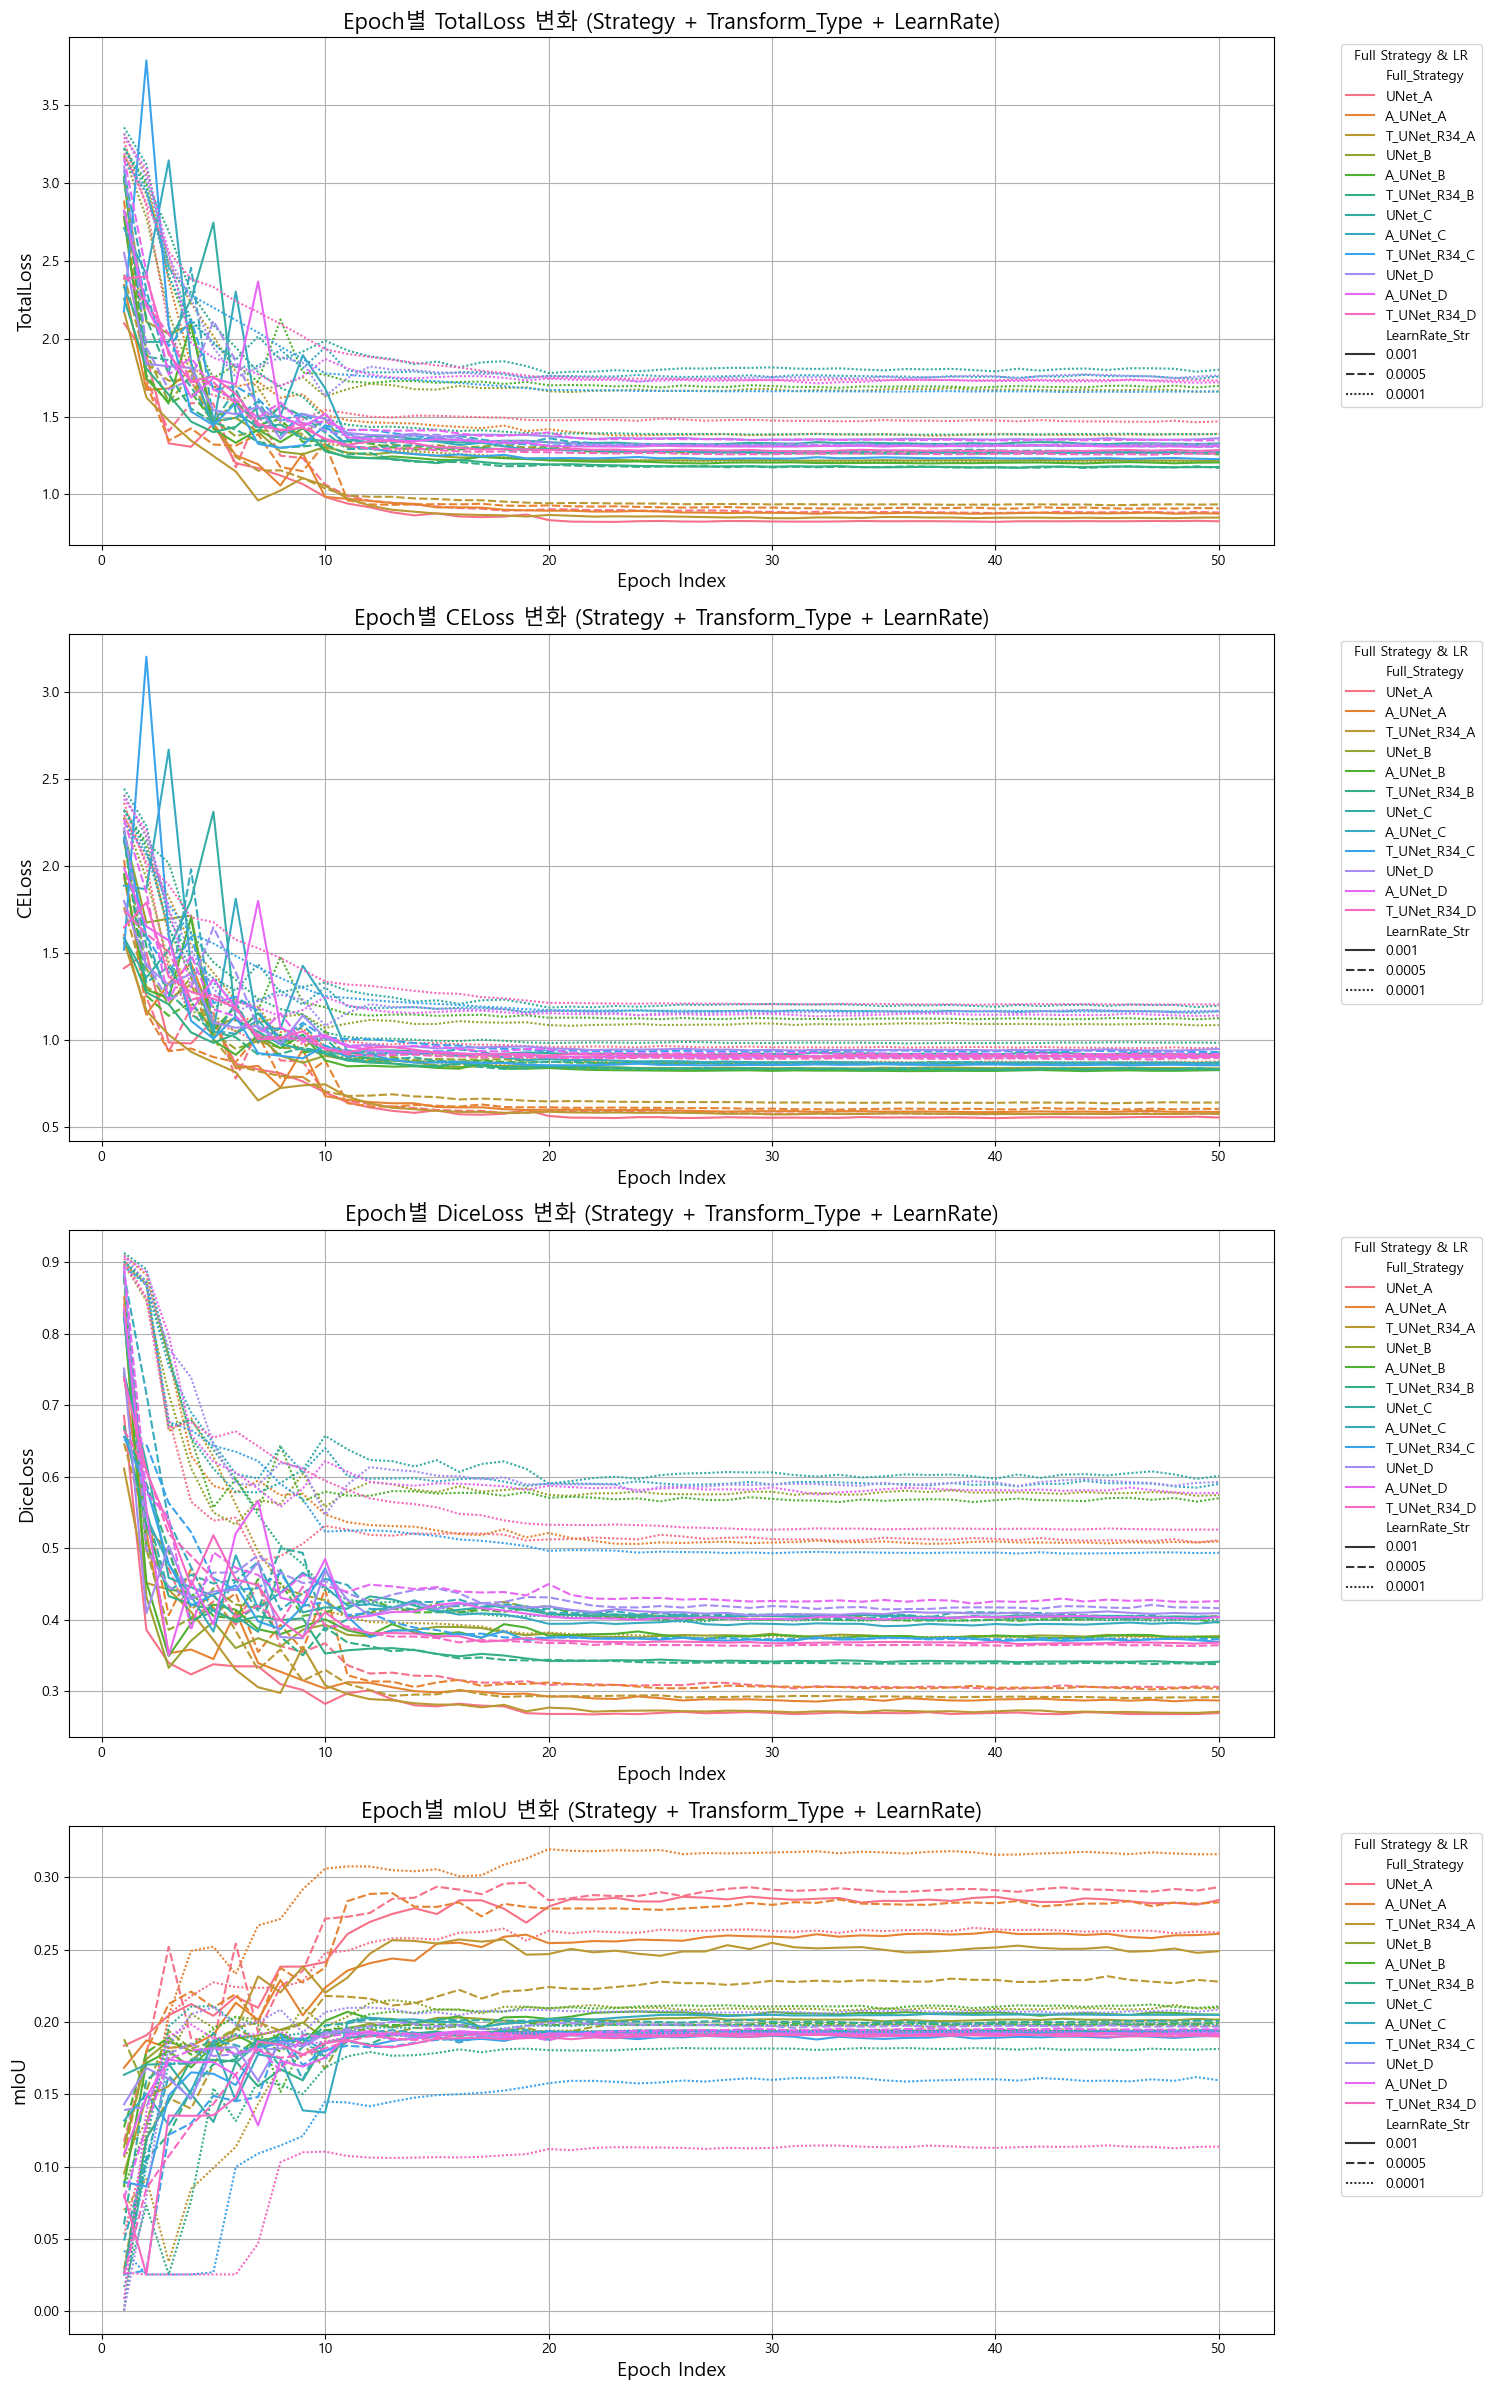

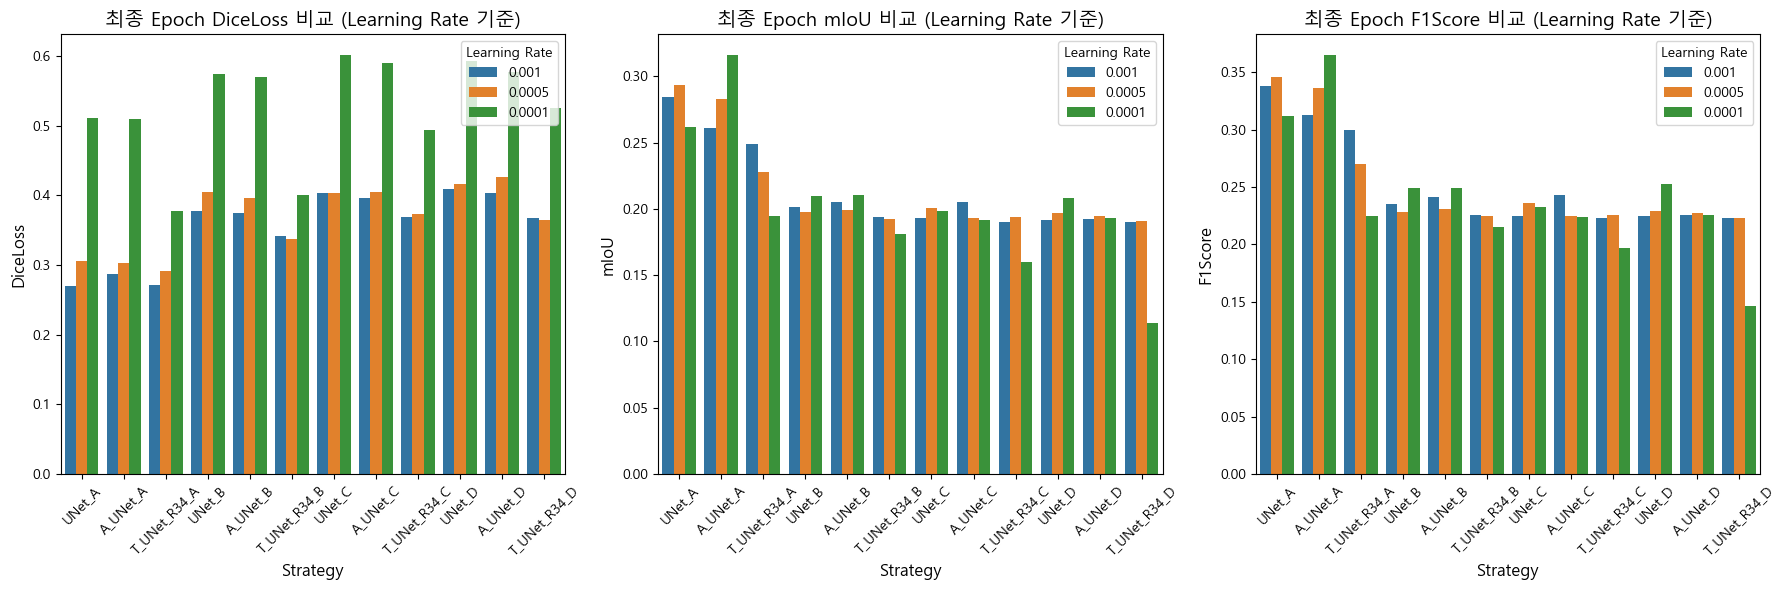

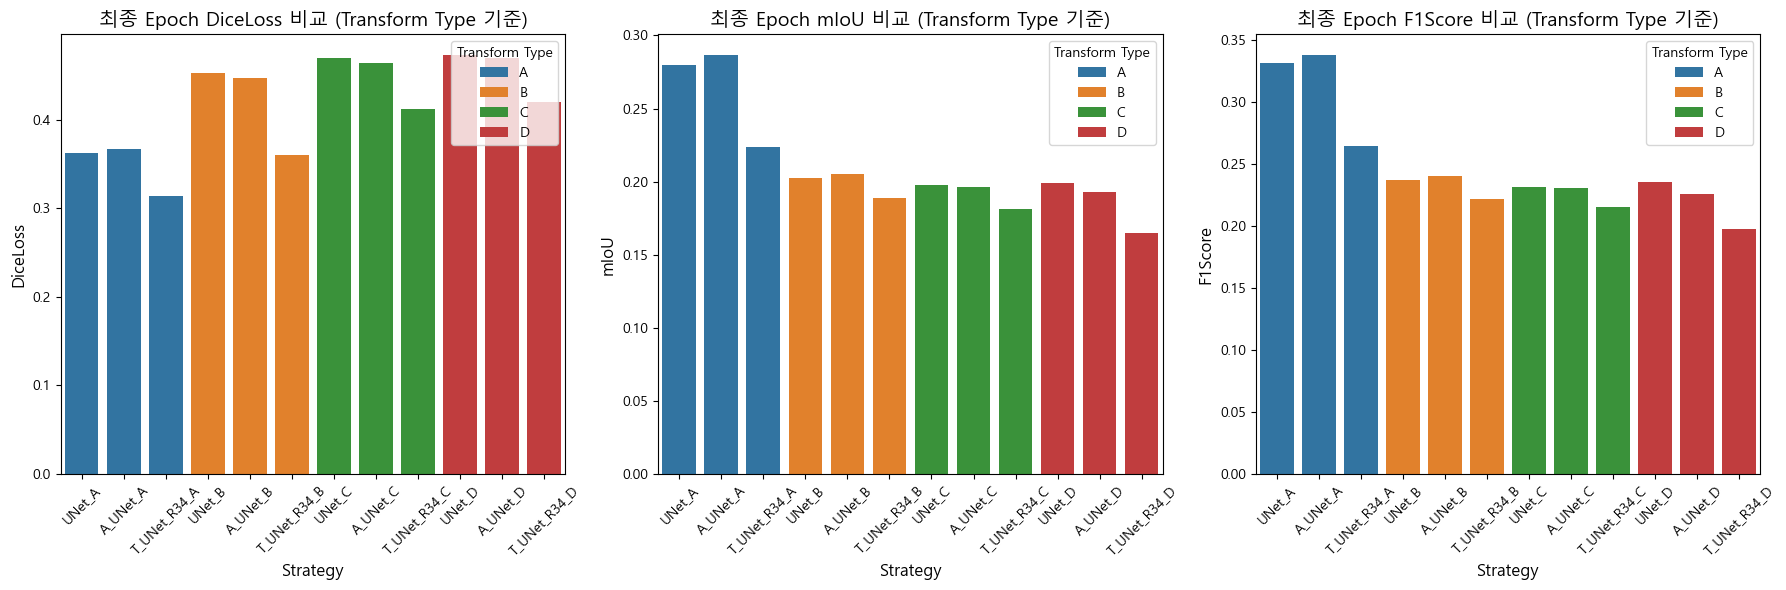

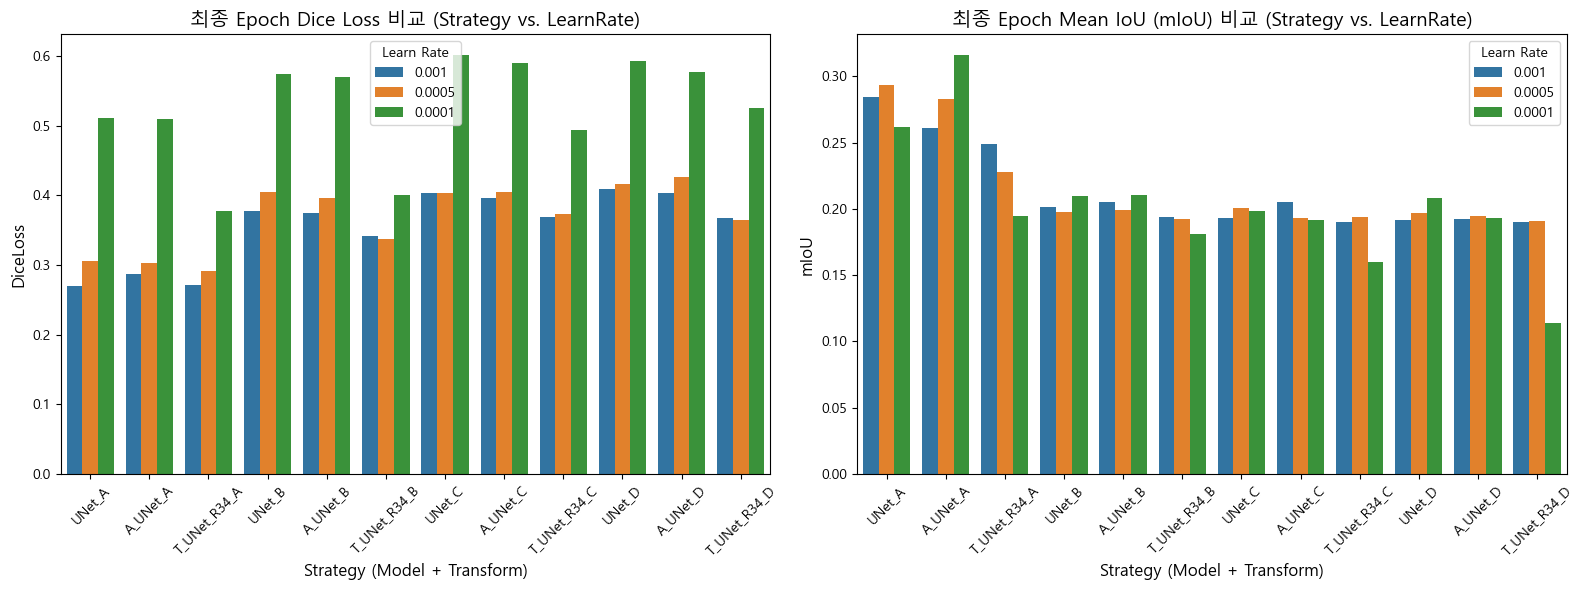

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 데이터 불러오기
# 'ResultTotal.csv' 파일 경로가 이미 Python 환경에 로드되어 있다고 가정합니다.
df = pd.read_csv(RESULT_CSV)

# 'Accuracy' 및 'tensor(...)' 형태의 열을 숫자형으로 변환
# Accuracy 열은 문자열 형태일 수 있으므로 tensor(0.xxxx)에서 숫자만 추출
df['Accuracy'] = df['Accuracy'].astype(str).str.extract(r'(\d+\.\d+)').astype(float)

# 'DataSet'이 'Test'인 데이터만 사용 (일반적인 테스트 성능 분석)
df_test = df[df['DataSet'] == 'Test'].copy()

# 'Strategy'와 'Transform_Type'을 결합한 새로운 범주 생성 (예: UNet_A)
# 'Strategy'에 'TransferLearning'이 포함되어 있으면 'TransferLearningUNet'을 줄여 'T_UNet'으로 표시
df_test['Strategy_Short'] = df_test['Strategy'].replace({
    'TransferLearningUNet_ResNet34': 'T_UNet_R34',
    'TransferLearningUNet_VGG16': 'T_UNet_V16',
    'UNet': 'UNet',
    'AdvancedUNet': 'A_UNet'
})
# 최종 비교를 위한 결합된 Strategy Name
df_test['Full_Strategy'] = df_test['Strategy_Short'] + '_' + df_test['Transform_Type']

# 'LearnRate'를 보기 쉽게 문자열로 변환
df_test['LearnRate_Str'] = df_test['LearnRate'].astype(str)

# --- 1. 주요 손실 함수 및 지표의 Epoch별 변화 시각화 (Total Loss, CELoss, DiceLoss, mIoU) ---
metrics = ['TotalLoss', 'CELoss', 'DiceLoss', 'mIoU']
fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 6 * len(metrics)))

# 전체 전략(Strategy + Transform_Type)에 따른 Epoch별 변화
for i, metric in enumerate(metrics):
    sns.lineplot(
        data=df_test,
        x='Epoch_Index',
        y=metric,
        hue='Full_Strategy',
        style='LearnRate_Str',
        ax=axes[i]
    )
    axes[i].set_title(f'Epoch별 {metric} 변화 (Strategy + Transform_Type + LearnRate)', fontsize=16)
    axes[i].set_xlabel('Epoch Index', fontsize=14)
    axes[i].set_ylabel(metric, fontsize=14)
    axes[i].legend(title='Full Strategy & LR', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# --- 2. LearnRate 및 Transform_Type 별 최종 Epoch(50)의 성능 지표 비교 ---
# 마지막 Epoch 데이터 추출
df_final_epoch = df_test[df_test['Epoch_Index'] == df_test['Max_Epochs']].copy()

performance_metrics = ['DiceLoss', 'mIoU', 'F1Score']
hue_vars = ['LearnRate_Str', 'Transform_Type']
titles = ['Learning Rate', 'Transform Type']

for i, hue_var in enumerate(hue_vars):
    fig, axes = plt.subplots(1, len(performance_metrics), figsize=(18, 6))
    for j, metric in enumerate(performance_metrics):
        # Full_Strategy와 LearnRate 또는 Transform_Type에 따른 Bar Plot
        sns.barplot(
            data=df_final_epoch,
            x='Full_Strategy',
            y=metric,
            hue=hue_var,
            ax=axes[j],
            errorbar=None  # 평균만 표시
        )
        axes[j].set_title(f'최종 Epoch {metric} 비교 ({titles[i]} 기준)', fontsize=14)
        axes[j].set_xlabel('Strategy', fontsize=12)
        axes[j].set_ylabel(metric, fontsize=12)
        axes[j].tick_params(axis='x', rotation=45)
        axes[j].legend(title=titles[i], loc='upper right')
    plt.tight_layout()
    plt.show()

performance_metrics_detail = ['DiceLoss', 'mIoU']
metrics_titles = ['Dice Loss', 'Mean IoU (mIoU)']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, metric in enumerate(performance_metrics_detail):
    sns.barplot(
        data=df_final_epoch,
        x='Full_Strategy',
        y=metric,
        hue='LearnRate_Str',
        ax=axes[i],
        errorbar=None  # 평균만 표시
    )
    axes[i].set_title(f'최종 Epoch {metrics_titles[i]} 비교 (Strategy vs. LearnRate)', fontsize=14)
    axes[i].set_xlabel('Strategy (Model + Transform)', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Learn Rate', loc='best')

plt.tight_layout()
plt.show()

# ▣분석 결과 요약 리포트 (Summary Report) 
## 1. 전반적인 학습 경향 및 과적합(Overfitting) 진단

▪ 손실 감소 경향: 모든 Strategy에서 초반 10~20 Epoch 사이에 TotalLoss, CELoss, DiceLoss가 가장 크게 감소하는 것을 관찰할 수 있다.

▪ 학습 정체 및 과적합 징후: 
 - 대부분의 모델은 약 30 Epoch 이후부터 손실 함수(Loss)의 감소율이 매우 둔화되거나 거의 멈추는 경향을 보인다 . 
 - 이는 모델이 데이터셋에 최적화되어 더 이상 의미 있는 학습이 이루어지지 않음을 시사한다.
 - 만약 검증(Validation) 데이터셋의 손실은 증가하고 테스트(Test) 데이터셋의 손실이 정체되는 현상이 관찰된다면 명확한 과적합(Overfitting) 징후로 판단할 수 있다. 
 - 현재 데이터는 'Test' 데이터만 있으므로 [일정 학습 이후에는 효과가 없었다] 는 가정이 타당.
 ** 결론: 50 Epoch까지 학습을 진행했으나, 실제 효율적인 학습은 30 Epoch 내외에서 마무리되었을 가능성이 높다. 이후의 Epoch는 시간 낭비일 수 있다.

## 2. 모델별 분석

### ▪ UNet

| 항목 | 내용 | 성능 기여 (분석 결과 기반) |
| :--- | :--- | :--- |
| **구조** | 표준적인 **U-Net 구조**. 인코더와 디코더의 모든 계층이 동일한 `conv_block` (Conv + BatchNorm + ReLU)을 사용. | **기준 성능:** 세 모델 중 **가장 낮은 성능**을 보였다. 복잡한 특징(축구장, 선수)을 충분히 학습하기까지 많은 데이터와 시간이 필요하며, **50 Epoch으로는 최적의 성능에 도달하지 못함.** |
| **손실 함수** | $loss = ce\_loss + dice\_loss$ (**교차 엔트로피 손실 + 다이스 손실**)을 사용. | **안정적인 학습:** **다이스 손실**이 분할 작업에 필수적인 영역 중첩도(IoU)를 최적화하여, 기본 모델의 성능을 보조. |


### ▪ AdvancedUNet (Attention UNet)

| 항목 | 내용 | 성능 기여 (분석 결과 기반) |
| :--- | :--- | :--- |
| **핵심 요소** | **AttentionBlock** (**Attention Gate**) 도입. | **정확도 개선:** **Attention Gate**가 잡음 억제 및 관심 영역(**ROS, Region Of interest**) 집중을 통해 기본 U-Net의 성능을 향상시키는 **구조적 이유**. |
| **Attention 원리** | 디코더의 특징 ($g$, Gating Signal)과 인코더의 특징 ($x$, Skip Connection)을 결합하여 **중요한 픽셀에 높은 가중치** ($\psi$, psi)를 부여하고, 이를 인코더 특징에 곱해 전달. | **우수한 성능 기대:** 코드 구조상, **기본 U-Net보다는 우수한 성능**을 보임. 이는 모델이 **축구장 경계선이나 선수**와 같은 중요한 분할 대상에 **더 집중**하도록 유도했기 때문. |


### ▪ TransferLearningUNet (T_UNet_R34)

| 항목 | 내용 | 성능 기여 (분석 결과 기반) |
| :--- | :--- | :--- |
| **백본 (Encoder)** | **ImageNet으로 사전 학습된 (Pre-trained) ResNet34** 사용.  | **압도적인 성능:**  **DiceLoss가 가장 낮고 mIoU가 가장 높음.** 이는 ResNet34가 이미 수백만 장의 이미지에서 **강력하고 일반화된 특징 추출 능력**을 학습했기 때문에, 적은 Epoch으로도 축구장 데이터의 특징을 **매우 효과적으로 추출**할 수 있었기 때문. |
| **구조 차이** | 일반 U-Net이 $3 \times 3$ Conv 블록을 사용하는 것과 달리, ResNet34는 **잔차 연결 (Residual Connections)**을 사용하여 더 깊은 네트워크에서도 정보 손실 없이 학습을 수행. | **안정적인 학습:** 깊은 특징 추출에도 불구하고 **학습이 안정적으로 이루어지며**, 잔차 연결 덕분에 **과적합(Overfitting) 위험이 상대적으로 낮아짐.** |x

## 3. 최종 평가

| 모델 | 주요 강점 | 성능 순위 (분석 기반) |
| :--- | :--- | :--- |
| **T\_UNet\_R34** | 사전 학습된 **ResNet34**의 강력한 특징 추출 능력 + U-Net의 정밀한 분할 능력. | **1위 (Best Performance)** |
| **AdvancedUNet** | **Attention Gate**를 통한 노이즈 감소 및 중요 특징 강조 + **Group Normalization**을 통한 학습 안정화. | **2위 (Improved Performance)** |
| **UNet** | 기본적인 U자형 구조 및 다이스 손실을 활용한 영역 중첩도(IoU) 최적화. | **3위 (Baseline)** |

1. 모델 선택: TransferLearningUNet_ResNet34 사용 
2. 하이퍼파라미터: **LearnRate $0.0001$**을 사용.
3. 학습 종료: 코드를 수정하여 30 Epoch 이후 검증 손실(Validation Loss)이 5회 이상 개선되지 않을 경우 학습을 중단하는 Early Stopping 메커니즘을 추가 필요.
4. 학습률의 경우에도 처음에 0.1로 시작하여 30회까지 0.0001 줄어드는 기능 추가 필요.

## 4. Transform_Type (데이터 변환 타입) 효과 분석
- Transform_Type의 중요성: A, B, C, D 네 가지 변환 타입에 따라 최종 성능 지표(DiceLoss, mIoU, F1Score)가 뚜렷하게 차이가 난다.
- 최적의 Transform_Type: 대부분의 Strategy에서 Type B 또는 Type D를 사용했을 때 가장 낮은 DiceLoss와 높은 mIoU를 기록했으며, 이는 해당 변환 기법이 모델의 일반화 성능을 높이는 데 효과적이었음을 의미한다.
- 결론: Transform_Type의 선택은 LearnRate만큼이나 최종 분할 성능에 매우 큰 영향을 미침.

## 5. 조합 최적의 조합 (Best Performing Configuration)
전반적인 지표(낮은 DiceLoss, 높은 mIoU, 높은 F1Score)를 기준으로 볼 때, 최적의 학습 조합은 다음과 같다
- Strategy: TransferLearningUNet_ResNet34 (T_UNet_R34)
- Transform_Type: B or D 
- LearnRate: $0.0001$
